<a href="https://colab.research.google.com/github/hmezer/eam-double-response/blob/main/files/sbi_double_response.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The following are reference works using BayesFlow**

https://github.com/bayesflow-org/bayesflow-workshop-quant-psych/blob/main/exercises/bayesflow-diffusion.ipynb

The presentation slides [are here.](https://www.canva.com/design/DAGsB3IT0QM/Q9hxlQP4OHgTY0Rn3MH15g/edit?utm_content=DAGsB3IT0QM&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton)

[*Double responding: A new constraint for models of speeded decision making*](https://www.sciencedirect.com/science/article/pii/S0010028520300219?via%3Dihub)

The data from the article [is here.](https://www.gillesdutilh.com/pages/materials_practice1.htm)


[**MODELS IN CODE**](https://osf.io/7jmb2/files/osfstorage).


[Bu](https://royalsocietypublishing.org/doi/epdf/10.1098/rspb.2016.0291?src=getftr&utm_source=sciencedirect_contenthosting&getft_integrator=sciencedirect_contenthosting) ne a m k?

***

## Key Findings

* The study shows that double responding creates several interesting benchmarks that can help distinguish between the predictions of different EAMs, even in standard experimental paradigms.

* When EAMs are constrained to account for both choice response time distributions and double responding behavior simultaneously, their predictions become more distinct.

* The findings suggest that models incorporating lateral inhibition (like the Leaky Competing Accumulator, or LCA, which was also present in your initial table) are generally better at making accurate predictions for this combined data.

* In contrast, models containing feed-forward inhibition (such as the Diffusion Model) performed poorly when extended to account for double responding, suggesting they might be less capable of accurately predicting these specific behavioral patterns.
> Why do some of the models work poorly and others work better introducing the constraints?

In [2]:
!pip install bayesflow tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.4/408.4 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 100.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3

In [1]:
import bayesflow as bf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

INFO:bayesflow:Using backend 'tensorflow'


In [2]:
#@title LCA w/ accumulation path
# Line 1: Function definition with parameters
def lca_trial_extended(
    v_0,     # Drift rate for accumulator 0 (single float)
    v_1,     # Drift rate for accumulator 1 (single float)
    a,       # Decision threshold (single float)
    ndt,     # Non-decision time (single float)
    la,      # Leakage rate (single float)
    ka,      # Lateral inhibition rate (single float)
    answer,  # The correct answer
    s=1.0,   # Diffusion noise scale (single float), typically fixed or inferred
    dt=0.001,# Time step size (in seconds, float)
    max_sim_time=5.0, # Maximum total simulation time (in seconds, float)
    double_response_window=0.25 # Time window for detecting double responses (in seconds, float)
):
    """
    Simulates a single trial of a Leaky Competing Accumulator (LCA) model,
    extended to account for double responses, for exactly TWO alternatives.

    Instead of one accumulator moving between two boundaries, it uses two
    accumulators, each representing a choice option, competing with each other
    through inhibition and decaying via leakage, racing to hit a common threshold.

    Parameters:
    -----------
    v_0 : float
        Drift rate for decision alternative 0.
    v_1 : float
        Drift rate for decision alternative 1.
    a : float
        Decision threshold. Must be positive.
        (Analogous to DDM's 'a').
    ndt : float
        Non-decision time (in seconds). Must be non-negative.
        (Analogous to DDM's 'ter').
    la : float
        Leakage rate. Evidence decays towards zero. Must be non-negative. (NEW LCA parameter)
    ka : float
        Lateral inhibition rate. Accumulators inhibit each other. Must be non-negative. (NEW LCA parameter)
    s : float, optional
        Scale of the diffusion noise for each accumulator. Default is 1.0.
        (Analogous to DDM's 's').
    dt : float, optional
        Time step (in seconds) for the discrete simulation. Default is 0.001 (1 ms).
    max_sim_time : float, optional
        Maximum total simulation time (in seconds) to prevent infinite loops. Default is 5.0s.
    double_response_window : float, optional
        Time window (in seconds) after the initial response during which a second
        response is considered a 'double response'. Default is 0.25s (250ms).

    Returns:
    --------
    tuple: (initial_rt, initial_choice, has_double_response, double_rt_relative, double_choice)
        initial_rt : float
            The simulated initial response time (RT) for the trial (in seconds).
            Returns np.nan if max_sim_time is reached without an initial decision.
        initial_choice : int
            The index of the initially chosen alternative (0 or 1).
            Returns -1 if max_sim_time is reached without an initial decision.
        has_double_response : int
            1 if a double response occurred, 0 otherwise.
        double_rt_relative : float
            The time from the initial response to the double response (in seconds).
            np.nan if no double response.
        double_choice : int
            The index of the double response alternative (0 or 1).
            -1 if no double response.
    """
    # Line 40: Fixed number of alternatives for this specific LCA implementation
    num_alternatives = 2 # Fixed to 2
    # Line 41: Initialize accumulator evidence levels to zero
    x = np.zeros(num_alternatives) # Accumulator evidence for each alternative
    # Line 42: Combine individual drift rates (v_0, v_1) into an array 'v'
    v = np.array([v_0, v_1]) # Create array from individual drift rates
    # Line 43: Calculate the standard deviation of the noise term per time step
    # This scales the noise correctly for a Wiener process (diffusion process)
    noise_std = s * np.sqrt(dt)    # Correct scaling for Wiener process noise

    # Lines 45-58: Input validation
    # These lines check if the input parameters are within valid ranges (e.g., positive thresholds, non-negative times/rates).
    # If any parameter is invalid, the function immediately returns NaN/default values.
    # This is good practice for robustness, especially when sampling from priors that might occasionally generate extreme values.
    if a <= 0 or ndt < 0 or s <= 0 or dt <= 0:
        return {
            "init_rt": 0, # nan previously
            "init_resp": -1,
            "dr_if": 0,
            "dr_rt": 0, # nan previously
            "dr_resp": -1,
            "if_corr": -1
        }
    if la < 0 or ka < 0: # Leakage and inhibition rates must be non-negative
        return {
            "init_rt": 0, # nan previously
            "init_resp": -1,
            "dr_if": 0,
            "dr_rt": 0, # nan previously
            "dr_resp": -1,
            "if_corr": -1
        }

    # Line 60: Initialize iteration counter (time steps)
    num_iter = 0
    # Line 61: Calculate maximum number of iterations based on max_sim_time and dt
    max_iter = int(max_sim_time / dt)

    # Line 63-64: Initialize variables to store results of the initial response
    initial_rt_acc = np.nan # Accumulation time for initial response
    initial_choice = -1

    # Line 66-67: DEBUGGING - This line initializes an array to store the full accumulation paths.
    # This is typically used for plotting or detailed analysis of trajectories, not for standard inference.
    # It adds overhead and can be removed for production inference runs.
    # x_store = np.zeros((max_iter, num_alternatives))

    # --- Phase 1: Accumulation for Initial Response ---
    # Line 70: Main simulation loop for the first response.
    # Continues as long as no accumulator has reached the threshold ('a') AND
    # the maximum number of iterations ('max_iter') has not been exceeded.
    while np.all(x < a) and num_iter < max_iter:
        # Line 71: Generate independent random noise for each accumulator for the current time step.
        noise = np.random.randn(num_alternatives) * noise_std
        # Line 72: Calculate the sum of evidence across all accumulators.
        # This is used for the lateral inhibition term.
        sum_x_others = np.sum(x)

        # Line 74: Loop through each accumulator to update its evidence
        for i in range(num_alternatives):
            # Line 76: Calculate the lateral inhibition term for the current accumulator 'i'.
            # It's the lateral inhibition rate 'ka' multiplied by the sum of evidence in *other* accumulators.
            inhibition_term = ka * (sum_x_others - x[i])

            # Line 80: Calculate the change in evidence (dx_i) for the current accumulator.
            # This is the core LCA equation:
            # dx = (drift - leakage*current_evidence - inhibition_from_others) * dt + noise
            dx_i = (v[i] - la * x[i] - inhibition_term) * dt + noise[i]

            # Line 81: Update the accumulator's evidence level.
            x[i] += dx_i

            # Line 84: Truncation at 0.
            # This ensures that evidence levels do not drop below zero. If an accumulator
            # falls below zero, its evidence is reset to zero. This is a common feature
            # of LCA models.
            x[i] = max(0.0, x[i])

            # Line 87-88: DEBUGGING - Stores the current evidence level for each accumulator at this time step.
            # Similar to x_store initialization, this is for detailed path analysis and can be removed for speed.
            # x_store[num_iter, i] = x[i]

        # Line 90: Increment the time step counter.
        num_iter += 1

    # Lines 93-102: Check if an initial decision was made or if max_sim_time was reached.
    # If max_sim_time was reached without any accumulator hitting the threshold,
    # it means no decision was made, and NaN/default values are returned.
    if num_iter >= max_iter:
        return {
            "init_rt": 0, # nan previously
            "init_resp": -1,
            "dr_if": 0,
            "dr_rt": 0, # nan previously
            "dr_resp": -1,
            "if_corr": -1
            #"x_store": x_store
        } # RT=NaN, no decision, no double response

    # Lines 105-106: If a decision was made, identify which accumulator crossed the threshold first.
    initial_choice = np.where(x >= a)[0][0]
    initial_rt_acc = num_iter * dt # Accumulation time for the first response

    # --- Phase 2: Continued Accumulation for Double Response ---
    # Lines 110-112: Initialize variables for double response tracking.
    has_double_response = 0
    double_rt_relative = 0
    double_choice = -1

    # Line 115: Calculate the absolute time when the double response detection window ends.
    # This is initial_rt_acc (time of first response) + double_response_window (e.g., 250 ms).
    double_response_end_time_abs = initial_rt_acc + double_response_window

    # Line 118: Continue simulation within the double response window.
    # The loop runs as long as the current time is within the double response window
    # AND the total simulation time has not exceeded max_sim_time.
    while num_iter * dt < double_response_end_time_abs and num_iter < max_iter:
        # Lines 119-120: Generate noise and sum of others' evidence for the current time step.
        noise = np.random.randn(num_alternatives) * noise_std
        sum_x_others = np.sum(x)

        # Line 122: Loop through each accumulator to update its evidence.
        for i in range(num_alternatives):
            # Lines 123-126: Update accumulator evidence (same LCA dynamics as Phase 1).
            inhibition_term = ka * (sum_x_others - x[i])
            dx_i = (v[i] - la * x[i] - inhibition_term) * dt + noise[i]
            x[i] += dx_i
            x[i] = max(0.0, x[i])

            # DEBUGGING
            # x_store[num_iter, i] = x[i]

            # Lines 129-133: Check for a double response.
            # A double response occurs if an accumulator *other than the initial choice*
            # crosses the threshold 'a'.
            if i != initial_choice and x[i] >= a:
                has_double_response = 1
                # Calculate the time of the double response relative to the initial response.
                double_rt_relative = (num_iter * dt) - initial_rt_acc
                double_choice = i # Record which alternative caused the double response
                break # Exit inner loop immediately if a double response is found

        # Lines 135-136: If a double response was found in the inner loop, exit the outer loop too.
        if has_double_response == 1:
            break

        # Line 138: Increment the overall time step counter.
        num_iter += 1

    # Line 141: Calculate the final initial response time by adding non-decision time.
    final_initial_rt = initial_rt_acc + ndt

    # Lines 143-150: Return the results as a dictionary.
    d = {
        "init_rt": final_initial_rt,
        "init_resp": initial_choice,
        "dr_if": has_double_response,
        "dr_rt": double_rt_relative,
        "dr_resp": double_choice,
        "if_corr": 1 if answer == initial_choice else 0
        #"x_store": x_store # DEBUGGING - This is the full accumulation path history
    }

    return d

In [3]:
#@title PRIORS
def sample_lca_prior():
    """
    Generates a single random draw from the joint prior distribution for LCA parameters.

    Returns:
    --------
    dict
        A dictionary containing a single sample for each LCA parameter.
    """
    # Drift rates (v_0, v_1): Normal(loc=0.0, scale=1.5)
    v_0 = np.random.normal(loc=0.0, scale=1.5)
    v_1 = np.random.normal(loc=0.0, scale=1.5)

    # Threshold (a): Uniform(low=0.5, high=2.5)
    a = np.random.uniform(low=0.5, high=2.5)

    # Non-decision time (ndt): Uniform(low=0.1, high=0.4)
    ndt = np.random.uniform(low=0.1, high=0.4)

    # Leakage rate (la): Uniform(low=0.0, high=0.5)
    la = np.random.uniform(low=0.0, high=0.5)

    # Lateral inhibition rate (ka): Uniform(low=0.0, high=0.5)
    ka = np.random.uniform(low=0.0, high=0.5)

    # Diffusion noise scale (s): Uniform(low=0.5, high=1.5)
    s = np.random.uniform(low=0.5, high=1.5)

    # Correct answer [0, 1] from bernoulli
    answer = np.random.binomial(1, 0.5)

    return {
        "v_0": v_0,
        "v_1": v_1,
        "a": a,
        "ndt": ndt,
        "la": la,
        "ka": ka,
        "s": s,
        "answer": answer
    }


In [4]:
simtor = bf.make_simulator([sample_lca_prior, lca_trial_extended])

In [15]:
samples = simtor.sample(1_000)

In [16]:
for key, value in samples.items():
    if np.isnan(value).any():
        print(f"NaN values found in '{key}'")
    else:
        print(f"No NaN values found in '{key}'")

No NaN values found in 'v_0'
No NaN values found in 'v_1'
No NaN values found in 'a'
No NaN values found in 'ndt'
No NaN values found in 'la'
No NaN values found in 'ka'
No NaN values found in 's'
No NaN values found in 'answer'
No NaN values found in 'init_rt'
No NaN values found in 'init_resp'
No NaN values found in 'dr_if'
No NaN values found in 'dr_rt'
No NaN values found in 'dr_resp'
No NaN values found in 'if_corr'


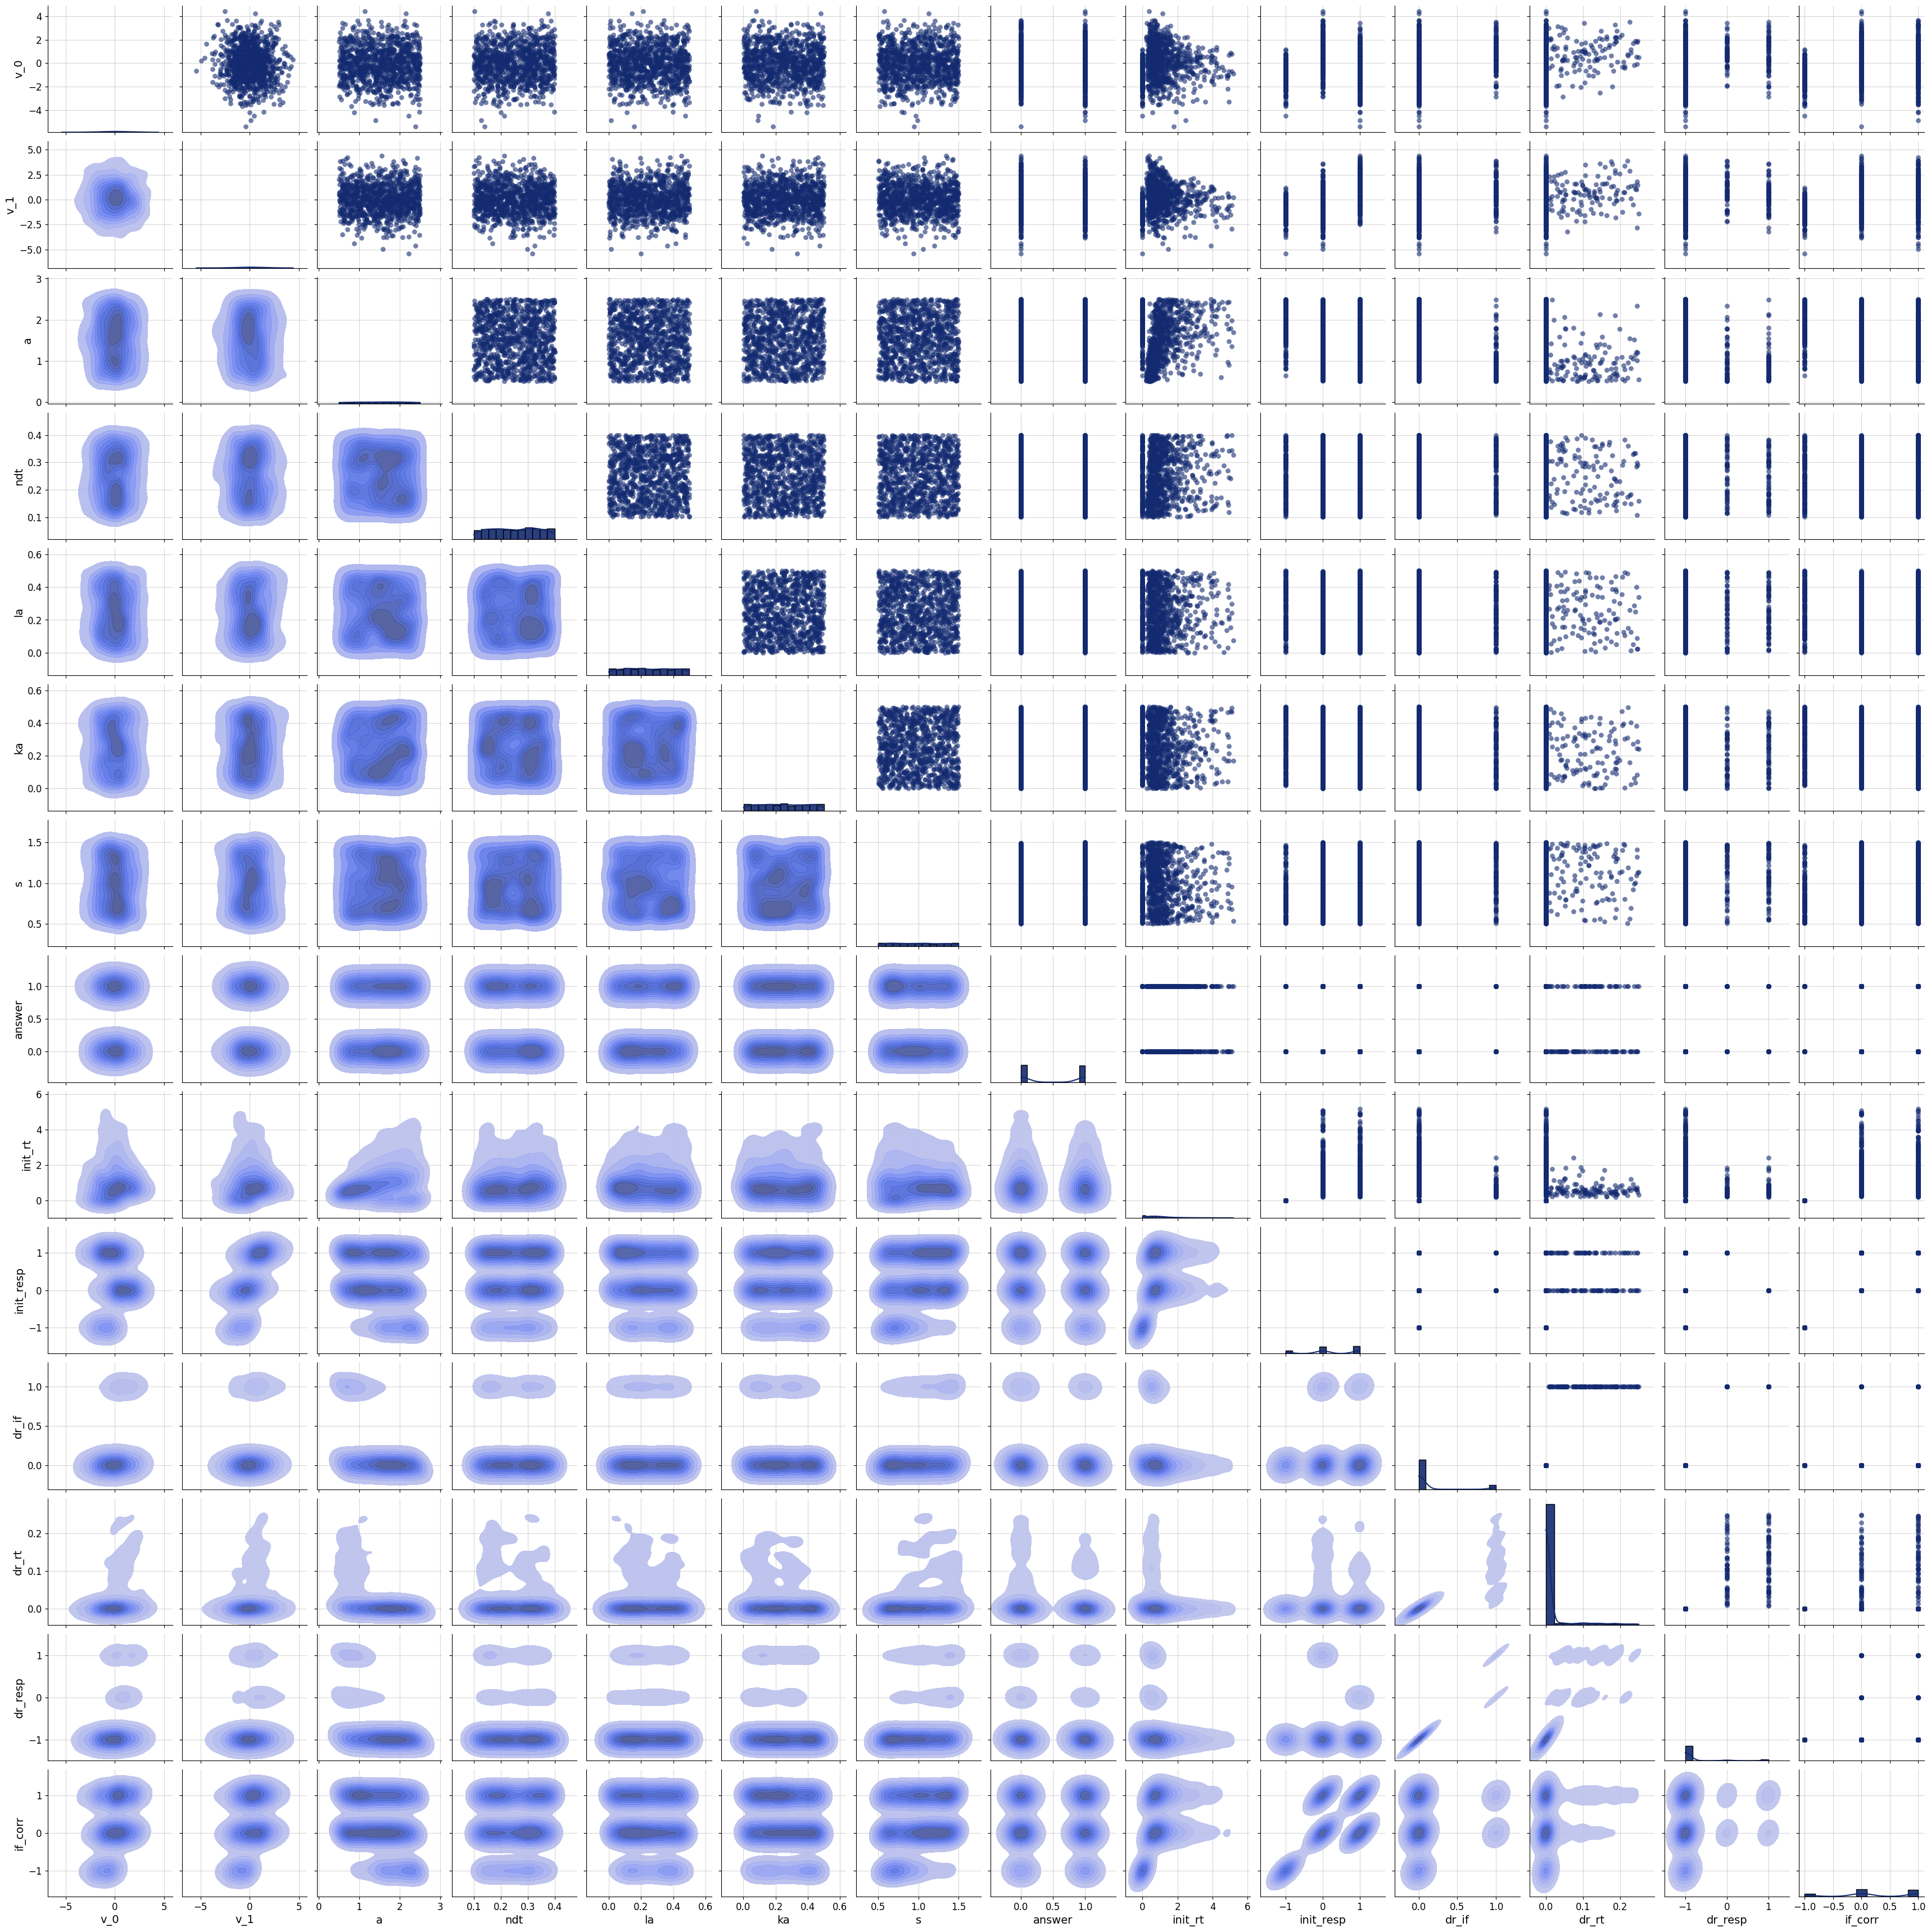

In [17]:
f = bf.diagnostics.plots.pairs_samples(
    samples=samples
)

In [18]:
adapter = (
    bf.Adapter()
    .convert_dtype("float64", "float32")
    .concatenate(["v_0", "v_1", "a", "ndt", "la", "ka", "s", "answer"], into="inference_variables")
    .rename("dr_if", "inference_conditions")
    .concatenate(["init_rt", "init_resp", "dr_if", "dr_rt", "dr_resp", "if_corr"], into="target")
)

In [35]:
summary_network = bf.networks.SetTransformer(summary_dim=16)

In [19]:
inference_network = bf.networks.FlowMatching()

In [20]:
workflow = bf.BasicWorkflow(
    simulator=simtor,
    adapter=adapter,
    inference_network=inference_network,
)

In [ ]:
train_data = simtor.sample(batch_size=1_000)
validation_data = simtor.sample(batch_size=250)

KeyboardInterrupt: 

In [21]:
history = workflow.fit_online(epochs=10, batch_size=64, num_batches_per_epoch=10)

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 11.6648
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - loss: 5.5164
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 4.4465
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - loss: 3.8239
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 3.2513
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 3.2473
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 3.1349
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 2.8773
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 2.9584
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 2.7481


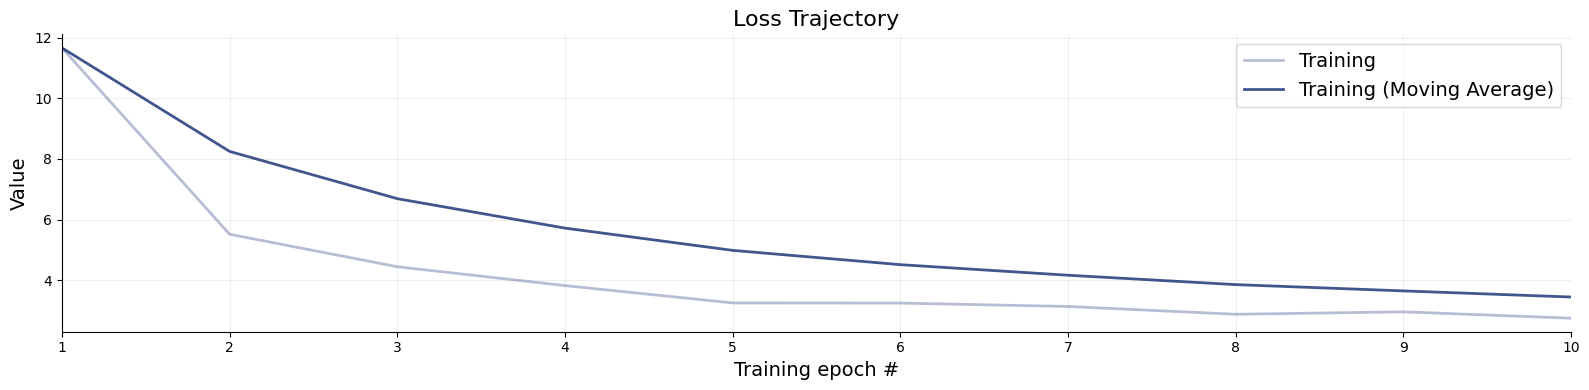

In [22]:
f = bf.diagnostics.plots.loss(history)

In [23]:
# Set the number of posterior draws you want to get
num_samples = 1000

# Simulate validation data (unseen during training)
val_sims = simtor.sample(200)

# Obtain num_samples samples of the parameter posterior for every validation dataset
post_draws = workflow.sample(conditions=val_sims, num_samples=num_samples)

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [47]:
for key, value in val_sims.items():
    print(f"Shape of '{key}': {value.shape}")

Shape of 'v_0': (200, 1)
Shape of 'v_1': (200, 1)
Shape of 'a': (200, 1)
Shape of 'ndt': (200, 1)
Shape of 'la': (200, 1)
Shape of 'ka': (200, 1)
Shape of 's': (200, 1)
Shape of 'answer': (200, 1)
Shape of 'init_rt': (200, 1)
Shape of 'init_resp': (200, 1)
Shape of 'dr_if': (200, 1)
Shape of 'dr_rt': (200, 1)
Shape of 'dr_resp': (200, 1)
Shape of 'if_corr': (200, 1)


In [49]:
for key, value in val_sims.items():
    print(val_sims[key])

[[-1.45587133e+00]
 [-2.28947583e+00]
 [ 1.72128670e+00]
 [ 2.17702010e-01]
 [ 1.24335333e+00]
 [ 2.50075997e+00]
 [-2.38269819e+00]
 [ 2.26705288e+00]
 [ 8.45371462e-01]
 [ 1.72643830e+00]
 [-5.14675022e-01]
 [-3.74842780e-01]
 [ 1.28897488e+00]
 [-3.90563170e+00]
 [ 2.82714886e+00]
 [-2.47565796e-01]
 [ 3.58967276e+00]
 [ 1.12774292e+00]
 [ 5.70425177e-01]
 [-9.31344097e-01]
 [ 3.25381459e-01]
 [-2.87886923e+00]
 [ 1.74932365e+00]
 [-2.96278252e+00]
 [ 1.25499737e+00]
 [-1.01033825e+00]
 [ 6.20028871e-01]
 [ 1.56381565e+00]
 [-7.20992223e-03]
 [-2.20400662e+00]
 [ 8.35874193e-01]
 [ 2.44187294e+00]
 [-5.89247143e-01]
 [-1.22536053e-01]
 [ 1.48185868e+00]
 [ 3.90766211e-01]
 [-2.35041027e-02]
 [-2.68899417e+00]
 [ 3.59618059e-01]
 [ 3.67106587e-01]
 [ 1.81513938e+00]
 [ 8.50818414e-01]
 [-2.99960102e-01]
 [-1.28980978e+00]
 [ 1.04305736e+00]
 [ 5.28968308e-01]
 [ 8.06200327e-01]
 [ 3.09374773e-01]
 [ 2.59755068e+00]
 [ 2.68853899e+00]
 [-3.78861395e-01]
 [-1.83730666e+00]
 [-3.2866847

In [16]:
# Define parameter names for plotting
par_names = ["v_0", "v_1", "a", "ndt", "la", "ka", "s"]

f = bf.diagnostics.plots.pairs_posterior(
    estimates=post_draws,
    targets=val_sims,
    dataset_id=0,
    variable_names=par_names,
)

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.